In [1]:
#Import Packages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy import stats
from scipy import interpolate
import matplotlib.cm as cm
import numpy.polynomial.polynomial as poly
%matplotlib inline

In [2]:
#Define Mars Year Range
FirstYear = 29
LastYear = 34

#Define Lat Lon of location in N and E format
lat = 0
lon = 0

#Define Range for use in determining first and last frost times (with errorbars)
Lsrange = 60

Years = np.linspace(FirstYear,LastYear,LastYear-FirstYear+1, dtype=int)

In [3]:
def pco2(T):
    '''
    # pco2
    # --------------------------------------------
    # Equilibrium vapor pressure over solid CO2
    # Brown and Ziegler (1980)
    # --------------------------------------------
    # Input:
    #    T = temperature of solid [K]
    # Output:
    #    vapor pressure [Pa]
    '''
    #Equation Coefficients
    A0 = 2.13807649e1
    A1 = -2.57064700e3
    A2 = -7.78129489e4
    A3 = 4.32506256e6
    A4 = -1.20671368e8
    A5 = 1.34966306e9
    # Pressure in torr
    ptorr = np.exp(A0 + (A1/(T)) + (A2/(T**2)) + (A3/(T**3)) + (A4/(T**4)) + (A5/(T**5)))
    # Pressure in Pa
    p = ptorr*133.3223684211
    return(p)

In [4]:
def tco2(p):
    '''
    #
    # tco2
    #
    #-------------------------------------------------------------------------
    #Calculate (approximately) the condensation temperature of CO2 at the
    #specified pressure(s) (Pa), using the empirical law from Brown and 
    #Ziegler (1980). This function calls the pco2() routine.
    #-------------------------------------------------------------------------
    # Input:
    #    p = vapor pressure [Pa]
    # Output:
    #    temperature of solid [K]
    '''
    Trange = np.arange(30,350)
    T = interpolate.pchip_interpolate(pco2(Trange),Trange,p)
    return(T)

In [5]:
def ls2sol(ls, n):
    '''
    # Function: ls2sol
    # Purpose: convert Mars "Lsubs" to sol (day of year)
    # Input: 
    #    ls = areocentric longitude of the Sun [array]
    #    n = degree of polynomial fit [scalar]
    '''
    # data
    lsdata = (0,30,60,90,120,150,180,210,240,270,300,330,360) # L_s array
    soldata = (0,61.2,126.6,193.3,257.8,317.5,371.9,421.6,468.5,514.6,562.0,612.9,668.6) # Sol array
    
    # polynomial fit
    p = np.polyfit(lsdata, soldata, n)
    
    # sol for Ls input
    sol = np.polyval(p, ls)
    
    # return result
    return(sol)

In [6]:
def MYretrieval(dataframe,Years):
    '''
    # Function: MYretrieval
    # Purpose: Separate data for each Mars year into their own Dataframes
    # Input: 
    #    dataframe = Dataframe not yet separated by Mars Year
    #    Years = Integer array or list of Mars years being retrieved
    '''
    #Initialize Dictionary
    dataframes = {}
    
    #Create Dictionary entry for each mars year
    for i in Years:
        dataframes[i] = dataframe[(dataframe['MY'] == i)]
    return(dataframes)

In [7]:
def CreateSubFrame(MarsDF, RanL_s, RanLat, RanLong):
    '''Function to divide previously created data frames in smaller data frames by providing ranges
    Input:
    MarsYearDF: Mars Data frames 
    RanL_s: range of Solar Longitude example [0,360]
    RanAlbedo: Albedo Range example [0.5,1.0]
    RanSZA Solar Zenith angle range example [0,45]
    RanLat and RanLong are set as default
    Output: Several Subframes'''
    L_s_MYDF = MarsDF['L_s']
    Lat_MYDF = MarsDF['Surf_lat']
    Long_MYDF = MarsDF['Surf_lon']
    MY_SUB = MarsDF[(L_s_MYDF <= RanL_s[-1])  & (L_s_MYDF >= RanL_s[0]) &
                        (Lat_MYDF <= RanLat[-1] ) & (Lat_MYDF >= RanLat[0]) & 
                        (Long_MYDF <= RanLong[-1]) & (Long_MYDF >= RanLong[0])]
    return(MY_SUB)

In [8]:
def column(MYDict, Parameter):
    '''Function to run statistics on data on the subframes from the dictionaries created by the SubDict function
    Input:
    MYDict: Dictionary Created by the SubDict Function
    Output:
    SubAvg: Average of the Albedo for each subframe in the dictionary
    SubStd: Standard Deviation of the Albedo for each subframe in the dictionary
    Sub_L_s: Average of the  Solar Longitude range for each subframe in the dictionary'''
    SubframeNum = len(MYDict.keys())
    SubTemp = []
    SubPres =[]
    SubMY = []
    SubLat =[]
    SubLong = []
    SubDust =[]
    SubSol = []
    SubStr = 'DataFrame{}'
    for i in range(SubframeNum):
        Subframe = MYDict[SubStr.format(i)]
        SubTemp.append((Subframe['T_surf'].values))
        SubPres.append((Subframe['p_surf'].values))
        SubMY.append((Subframe['MY'].values))
        SubLat.append((Subframe['Surf_lat'].values))
        SubLong.append((Subframe['Surf_lon'].values))
        SubDust.append((Subframe['Dust_column'].values))
        SubSol.append((Subframe['Sol'].values))
    SubTemp = np.array(SubTemp)
    SubPres = np.array(SubPres)
    SubMY = np.array(SubMY)
    SubLat = np.array(SubLat)
    SubLong = np.array(SubLong)
    SubDust = np.array(SubDust)
    SubSol = np.array(SubSol)
    if Parameter =='Temperature':
        return(SubTemp)
    elif Parameter =='Pressure': 
        return(SubPres)
    elif Parameter =='Martian Year':
        return(SubMY)
    elif Parameter =='Latitude':
        return(SubLat)
    elif Parameter =='Longitude':
        return(SubLong)
    elif Parameter =='Dust Column':
        return(SubDust)
    elif Parameter =='Sol':
        return(SubSol) 

In [9]:
def IRFlux(T):
    '''Calculate the luminosity of the thing.
    Input:
    T = Temperature
    Output:
    boltz = luminosity'''
    sigma = 5.67e-8 # W/m**2/K**4
    boltz = sigma * T**4
    return(boltz)

In [10]:
def emi(temp,frosttemp):
    sigma = 5.67e-8
    a = IRFlux(temp)
    b = IRFlux(frosttemp)
    emi = a/b
    return(emi)

In [11]:
def square(lat,lon,size=59.157935, box = 'km'): # 1 degree latitude
    '''Function to draw equal length trapezoid that are latitude dependent
    Inputs:
    Latitude = array or float, latitude of the locations
    Longitude = array or float, longitude of the locations
    Size = size of the box default is equal to one degree by one degree could be kilometers or degrees
    type = string, if input is km the size argument is inputed as kilometers else, deg is inputed as degrees
    Outputs:
    lower_lat = lower latitude 
    upper_lat = upper latitude 
    right_lon = right longitude corner
    left_lon = left longitude corner'''
    radius = 3389.5 #Mars radius in km
    d2r = np.pi/180 #Degree to Radians
    if box == 'km': #Calculate box location from km
        lat_deg = size*180/(np.pi*radius)
        upper_lat = lat + .5 * lat_deg
        lower_lat = lat - .5 * lat_deg
        lon_deg = size / (np.pi * np.cos(upper_lat*d2r) / 180)
        left_lon = lon - .5 * lon_deg * size
        right_lon = lon + .5 * lon_deg * size
        return(lower_lat, upper_lat, right_lon, left_lon)
    elif box == 'deg': #Calculate box location from degrees
        upper_lat = lat + .5 * size
        lower_lat = lat - .5 * size
        leng = radius * np.pi * np.cos(upper_lat*d2r)*2 #Longitude Size of box based on upper latitude
        lon_deg = 59.157935*size/leng*360
        left_lon = lon - .5 * lon_deg 
        right_lon = lon + .5 * lon_deg
        return(lower_lat, upper_lat, right_lon, left_lon)

In [12]:
def xerr(a,b,covmat):
    '''Function to calculate the x-intercept of a fitted line in the form y = ax+b with its error
    Inputs:
    a = float, the slope of the fitted line
    b = float, the x intercept of the line
    covmat = array, the covariance matrix of the fitted line
    Outputs:
    x = float, the x-intercept of the line
    stdx = float , error of the line '''
    x = -b/a
    stdx = x*np.sqrt((covmat[1,1]/(b**2))+(covmat[0,0]/(a**2))-2*((covmat[0,1]/(a*b))))
    return(x, stdx)

In [13]:
def PosFrost(dataframe):
    # Confirm there are areas that could accumulate frost
    Location = np.sum(dataframe['T_surf'] <= dataframe['Frost_T'])
    if Location == 0:
        return(False)
    else:
        return(True)

In [14]:
def IndexLoc(DayDF, NightDF, Years, Lsrange):
    '''
    # Function: IndexLoc
    # Purpose: Find the rough LS of the first and last frosts for both day and night
    # Input: 
    #    DayDF = Dictionary of Mars year data during the day time
    #    NightDF = Dictionary of Mars year data during the night time
    #    Years = Integer array or list of Mars years being retrieved
    #    Lsrang = Range of data to focus on for polyfit lines
    '''
    DayBool = {}
    NightBool = {}
    FFDayLs = {}
    LFDayLs = {}
    FFNightLs = {}
    LFNightLs = {} 
    for i in Years:
        # Find if the current year has times cold enough to have frost
        DayBool[i] = (DayDF[i]['T_surf'] <= DayDF[i]['Frost_T'])
        NightBool[i] = (NightDF[i]['T_surf'] <= NightDF[i]['Frost_T'])
        # If the day time can have frost return its first and last frost times and their corresponding ranges
        if np.any(DayBool[i]) == True:
            smallday = DayBool[i][DayBool[i] == True].index[0]
            largeday = DayBool[i][DayBool[i] == True].index[-1]
            FFDayLs[i] = [DayDF[i]['L_s'][smallday]-Lsrange/2.0,
                          DayDF[i]['L_s'][smallday],
                          DayDF[i]['L_s'][smallday]+Lsrange/2.0]
            LFDayLs[i] = [DayDF[i]['L_s'][largeday]-Lsrange/2.0,
                          DayDF[i]['L_s'][largeday],
                          DayDF[i]['L_s'][largeday]+Lsrange/2.0]
        else: # Otherwise set default values
            FFDayLs[i] = [0,0,0]
            LFDayLs[i] = [0,0,0]
        # If the night time can have frost return its first and last frost times and their corresponding ranges
        if np.any(NightBool[i]) == True:
            smallnight = NightBool[i][NightBool[i] == True].index[0]
            largenight = NightBool[i][NightBool[i] == True].index[-1]
            FFNightLs[i] = [NightDF[i]['L_s'][smallnight]-Lsrange/2.0,
                            NightDF[i]['L_s'][smallnight],
                            NightDF[i]['L_s'][smallnight]+Lsrange/2.0]
            LFNightLs[i] = [NightDF[i]['L_s'][largenight]-Lsrange/2.0,
                            NightDF[i]['L_s'][largenight],
                            NightDF[i]['L_s'][largenight]+Lsrange/2.0]
        else: # Otherwise set default values
            FFNightLs[i] = [0,0,0]
            LFNightLs[i] = [0,0,0]
    return([FFDayLs, LFDayLs, FFNightLs, LFNightLs])

In [15]:
def FrostFit(DayDf, NightDf, Years, FrostTimes):
    '''
    # Function: FrostFFit
    # Purpose: Do a polyfit and find the error associated with every First and Last frost time
    # Input: 
    #    DayDF = Dictionary of Mars year data during the day time
    #    NightDF = Dictionary of Mars year data during the night time
    #    Years = Integer array or list of Mars years being retrieved
    #    FrostTimes = Rough estimate for range of data's frost time
    '''    
    
    FirstFrostDF = pd.DataFrame()
    LastFrostDF = pd.DataFrame()
    
    # For every year and time perform a polyfit and error analysis to find a more precise LS for frost timing
    for i in Years:
        
        #Return the data associated with the daytime first frost
        DayFFIndex = DayDf[i].index[np.where(DayDf[i]['L_s']>= FrostTimes[0][i][0]) and 
                                np.where(DayDf[i]['L_s']<= FrostTimes[0][i][-1])]
        DayFF[i]= DayDf[i].loc[DayFFIndex]
        DayFF[i]['T_diff'] =  DayFF[i]['T_surf'] - DayFF[i]['Frost_T']
        
        #Return the data associated with the daytime lasst frost
        DayLFIndex = DayDf[i].index[np.where(DayDf[i]['L_s']>= FrostTimes[1][i][0]) and 
                                np.where(DayDf[i]['L_s']<= FrostTimes[1][i][-1])]
        DayLF[i]= DayDf[i].loc[DayLFIndex]
        DayLF[i]['T_diff'] =  DayLF[i]['T_surf'] - DayLF[i]['Frost_T']
        
        #Return the data associated with the nighttime first frost
        NightFFIndex = NightDf[i].index[np.where(NightDf[i]['L_s']>= FrostTimes[2][i][0]) and 
                                np.where(NightDf[i]['L_s']<= FrostTimes[2][i][-1])]
        NightFF[i]= NightDf[i].loc[NightFFIndex]
        NightFF[i]['T_diff'] =  NightFF[i]['T_surf'] - NightFF[i]['Frost_T']
        
        #Return the data associated with the nighttime last frost
        NightLFIndex = NightDf[i].index[np.where(NightDf[i]['L_s']>= FrostTimes[3][i][0]) and 
                                np.where(NightDf[i]['L_s']<= FrostTimes[3][i][-1])]
        NightLF[i]= NightDf[i].loc[NightLFIndex]
        NightLF[i]['T_diff'] =  NightLF[i]['T_surf'] - NightLF[i]['Frost_T']
    
        #Perfrom the polyfit on the data ranges and return their covariance matrices
        DFFCovMat[i] = np.polyfit(DayFF[i]['L_s'], DayFF[i]['T_diff'], 1, cov=True)
        DLFCovMat[i] = np.polyfit(DayLF[i]['L_s'], DayLF[i]['T_diff'], 1, cov=True)
        NFFCovMat[i] = np.polyfit(NightFF[i]['L_s'], NightFF[i]['T_diff'], 1, cov=True)
        NLFCovMat[i] = np.polyfit(NightLF[i]['L_s'], NightLF[i]['T_diff'], 1, cov=True)
        
        #Find the error associated with each covariance matrix
        #Caution 4-D array... we do not advise playing with it.
        DayFFErr[i] = xerr(DFFCovMat[i][0][0],DFFCovMat[i][0][1], DFFCovMat[i][1])
        DayLFErr[i] = xerr(DLFCovMat[i][0][0],DLFCovMat[i][0][1], DLFCovMat[i][1])
        NightFFErr[i] = xerr(NFFCovMat[i][0][0],NFFCovMat[i][0][1], NFFCovMat[i][1])
        NightLFErr[i] = xerr(NLFCovMat[i][0][0],NLFCovMat[i][0][1], NLFCovMat[i][1])
        
    return([DayFF, DayLF, NightFF, NightLF, DFFCovMat, DLFCovMat, 
            NFFCovMat, NLFCovMat, DayFFErr, DayLFErr, NightFFErr, NightLFErr])

In [16]:
def PeakTemp(Dataframe, Years):
    Peaks = []
    for i in Years:
        Peaks.append(Dataframe.loc[Dataframe[Dataframe['MY'] == i]['T_surf'].idxmax(), 'L_s'])
    return(Peaks)

In [17]:
#read data into dataframe
df = pd.read_csv('../WORK/surf_bT_ret_171031.txt', header=None, delimiter=r"\s+",
                 names = [' ',
                          'UTC',
                          'MY',
                          'L_s',
                          'LTST',
                          'Surf_lat',
                          'Surf_lon',
                          'Surf_rad',
                          'Surf_elev',
                          'T_surf',
                          'T_surf_err',
                          'Dust_column',
                          'Dust_column_err',
                          'H2Oice_column',
                          'H2Oice_column_err',
                          'p_surf',
                          'p_surf_err',
                          'P_qual',
                          'T_qual'])

In [18]:
df['Sol'] = ls2sol(df['L_s'],8)
dfday = df[df['LTST'] >= .5]
dfnight = df[df['LTST'] <= .5]

In [19]:
cond = (df['MY'],df['L_s'],pco2(df['T_surf']), df['p_surf'], tco2(df['p_surf']), df['T_surf'], df['LTST'], df['Surf_lat'], df['Surf_lon'], df['Dust_column'] , df['Sol'] )
cond_right= np.transpose(cond)
CO2 = pd.DataFrame(list(cond_right))
CO2.columns = ['MY','L_s','Eq_Vap_P','p_surf','Frost_T','T_surf','LTST', 'Surf_lat', 'Surf_lon', 'Dust_column', 'Sol']

In [20]:
newCO2 = CO2[CO2['Eq_Vap_P'] <= CO2['p_surf']]

In [21]:
CO2day = CO2[CO2['LTST'] >= 0.5]
CO2night = CO2[CO2['LTST'] <= 0.5]

In [22]:
dfday['L_s'] = dfday['L_s']+(dfday['MY']-(FirstYear))*360
dfnight['L_s'] = dfnight['L_s']+(dfnight['MY']-(FirstYear))*360
CO2day['L_s'] = CO2day['L_s']+(CO2day['MY']-(FirstYear))*360
CO2night['L_s'] = CO2night['L_s']+(CO2night['MY']-(FirstYear))*360

/anaconda2/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda2/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda2/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [23]:
def LocFunc(Day, Night, CO2D, CO2N, lat, lon, Years, Lsrange=50, size=59.157935, box='km'):
    #Constrain box of data based on location and box parameters
    Location = square(lat, lon, size, box)
    Frost = 0
    
    # Try to find frost for each mars year at the given location
    Day.insert(10 , 'Frost_T', CO2D['Frost_T'])
    Night.insert(10 , 'Frost_T', CO2N['Frost_T'])
    Day.insert(11, 'Tdiff', Day['T_surf'] - Day['Frost_T'])
    Night.insert(11, 'Tdiff', Night['T_surf'] - Night['Frost_T'])

    #Only retrieve data that exists within the area specified
    Day = CreateSubFrame(Day, np.linspace(0,360*(Years[-1]-Years[0]+1)), np.linspace(Location[0],Location[1]), np.linspace(Location[3],Location[2]))
    Night = CreateSubFrame(Night, np.linspace(0,360*(Years[-1]-Years[0]+1)), np.linspace(Location[0],Location[1]), np.linspace(Location[3],Location[2]))
    
    #Look for frost at the location
    Frost = PosFrost(Day) + PosFrost(Night) + Frost
    
    #If there is frost, continue
    if Frost > 0:
        Peaks = PeakTemp(Day,Years)
        plt.rcParams['figure.figsize'] = [22,11]
        #plt.scatter(Day['L_s'],Day['T_surf'])
        #plt.scatter(Day['L_s'],Day['Frost_T'])
        #plt.scatter(Day['L_s'],Day['Tdiff'])
        #for i in range(len(Years)):
        #    plt.axvline(360+360*i, c='k')
        #    plt.axvline(Peaks[i], c='r')
        #plt.show()
        FirstFrostDay, LastFrostDay = frost(Day,Years,Peaks,Lsrange)
        FirstFrostNight, LastFrostNight = frost(Night,Years,Peaks,Lsrange)
        #print(FirstFrost)
        #print(LastFrost)
        PlotFit(Day, Night, Years, lat, lon, FirstFrostDay, LastFrostDay, FirstFrostNight, LastFrostNight, Lsrange)
    else: #Otherwise output that there was no frost
        print('No CO2 frost detected')
    return(Day, Night)

In [42]:
def frost(Dataframe,Years,Peaks,Range):
    # binned data across the entire dataset
    binmeans,_,_ = stats.binned_statistic(Dataframe['L_s'], 
                                          Dataframe['Tdiff'], 
                                          statistic = 'median', 
                                          bins = (max(Dataframe['L_s'])-min(Dataframe['L_s']))/2, #2 bins per degree Ls
                                          range=[min(Dataframe['L_s']),max(Dataframe['L_s'])])
        
    # Times matching each bin
    bintimes = np.linspace(min(Dataframe['L_s']), max(Dataframe['L_s']), (max(Dataframe['L_s'])-min(Dataframe['L_s']))/2)
    # Return values that are not NaN
    bintimes = bintimes[np.invert(np.isnan(binmeans))]
    binmeans = binmeans[np.invert(np.isnan(binmeans))]
    
    for i in range(len(Peaks)):
        try:
            if i == 0:
                #Isolate the times between 0 and the first peak, only for when i == 0
                timeindeces = np.where(bintimes <= Peaks[i])
                means = binmeans[timeindeces]
                meanindeces = np.where(means <= 0)
                try:
                    FFtime = min(bintimes[meanindeces])
                    LFtime = max(bintimes[meanindeces])
                except:
                    FFtime = 359
                    LFtime = 359

            else:
                #Isolate the times between peak i-1 and peak i for the rest of the intervals
                timeindeces = np.where(bintimes <= Peaks[i]) #find times before the last bounding peak
                times = bintimes[timeindeces] #apply indeces to times
                means = binmeans[timeindeces] #apply indeces to means
                timeindeces = np.where(times >= Peaks[i-1]) #find times after the first bounding peak
                means = means[timeindeces] #apply indeces to means again
                times = times[timeindeces]
                meanindeces = np.where(means <= 0) #of the restricted means, find values less than 0
                try:
                    FFtime = min(times[meanindeces]) #return the time where the mean is first below 0
                    LFtime = max(times[meanindeces]) #return the time where the mean is last below 0
                except:
                    FFtime = 359
                    LFtime = 359

            FFmod = FFtime%360
            LFmod = LFtime%360

            Fx = (Dataframe['L_s'].loc[Dataframe['L_s'] >= (FFtime-Range/2)].loc[Dataframe['L_s'] <= (FFtime+.5)])
            Fy = (Dataframe['Tdiff'].loc[Dataframe['L_s'] >= (FFtime-Range/2)].loc[Dataframe['L_s'] <= (FFtime+.5)])
            Fx = Fx[Fy >= -10.0]
            Fy = Fy[Fy >= -10.0]
            Fx = Fx[Fy <= 20.0]
            Fy = Fy[Fy <= 20.0]
            Lx = (Dataframe['L_s'].loc[Dataframe['L_s'] >= (LFtime-.5)].loc[Dataframe['L_s'] <= (LFtime+Range/2)])
            Ly = (Dataframe['Tdiff'].loc[Dataframe['L_s'] >= (LFtime-.5)].loc[Dataframe['L_s'] <= (LFtime+Range/2)])
            Lx = Lx[Ly >= -10.0]
            Ly = Ly[Ly >= -10.0]
            Lx = Lx[Ly <= 20.0]
            Ly = Ly[Ly <= 20.0]

            FFcoe, FFcov = np.polyfit(Fx, Fy, 1, cov = True)
            LFcoe, LFcov = np.polyfit(Lx, Ly, 1, cov = True)

            FFerr = xerr(FFcoe[0],FFcoe[1],FFcov)
            LFerr = xerr(LFcoe[0],LFcoe[1],LFcov)

            FMY = np.int(FFerr[0]/360+Years[0])
            if FFmod > LFmod:
                LMY = np.int(LFerr[0]/360+Years[0])
            else:
                LMY = np.int(LFerr[0]/360+Years[0])

            Period = LFerr[0]-FFerr[0]

            FFmod = FFerr[0]%360
            LFmod = LFerr[0]%360

            ShiftFF = FFerr[0] - FFmod
            ShiftLF = LFerr[0] - LFmod

            if i == 0:
                FFdata = [FMY,i,FFerr[0],FFerr[1],Period,FFmod,FFcoe[0],FFcoe[1],ShiftFF]
                LFdata = [LMY,i,LFerr[0],LFerr[1],Period,LFmod,LFcoe[0],LFcoe[1],ShiftLF]
            else:
                FFdata = np.row_stack((FFdata,[FMY,i,FFerr[0],FFerr[1],Period,FFmod,FFcoe[0],FFcoe[1],ShiftFF]))
                LFdata = np.row_stack((LFdata,[LMY,i,LFerr[0],LFerr[1],Period,LFmod,LFcoe[0],LFcoe[1],ShiftLF]))
        except:
            if i == 0:
                FFdata = [0,i,-3,9,9,9,9,9,9]
                LFdata = [0,i,-3,9,9,9,9,9,9]
            else:
                FFdata = np.row_stack((FFdata,[9,i,-3,9,9,9,9,9,9]))
                LFdata = np.row_stack((LFdata,[9,i,-3,9,9,9,9,9,9]))

    FirstFrostDF = pd.DataFrame(data=FFdata,columns=['MY', 'Winter', 'L_s', 'std', 'Period', 'LsMod', 'coe1', 'coe2', 'Shift'])
    LastFrostDF = pd.DataFrame(data=LFdata,columns=['MY', 'Winter', 'L_s', 'std', 'Period', 'LsMod', 'coe1', 'coe2', 'Shift'])
    return(FirstFrostDF,LastFrostDF)


In [121]:
def PlotFit(Day, Night, Years, lat, lon, FFD, LFD, FFN, LFN, Lsrange):
    '''
    # Function: PlotYear
    # Purpose: Plot Surface Temperature and Frost Temperature curves, the
    #          first and last frost fitted lines with error bars, and any
    #          any other associated data that needs to be plotted
    # Input: 
    #    Day = Dictionary of Mars year data during the day time
    #    Night = Dictionary of Mars year data during the night time
    #    Years = Integer array or list of Mars years being retrieved
    #    lat = latitude of the location being plotted
    #    lon = longitude of the location beign plotted
    '''  
    plt.rcParams['figure.figsize'] = [22,132]
    plt.rcParams.update({'font.size':15})
    
    #Plot Whole Daytime Dataset
    
    ax0 = plt.subplot2grid((len(FFD['Winter'])*2+7,2),(0,0),colspan=2,rowspan=2)
    plt.scatter(Day['L_s'],Day['Tdiff'])
    for i in range(len(Years)):
        plt.axvline(360+360*i, c='k')
        #plt.axvline(Peaks[i], c='r')
    plt.xlabel('${L_s}$')
    plt.ylabel('Surface Temp - Frost Temp (K)')
    plt.title('Continuous Daytime Surface Temp - Frost Temp for MY {} to {}'.format(Years[0], Years[-1]))
    plt.show()
    

    for i in FFD['Winter']: 
            #Plot Daytime First Frost Fit
        try:
            ax1 = plt.subplot2grid((len(FFD['Winter'])*2+7,2),(3+int(i),0))
            Ls = Day['L_s'].loc[Day['L_s'] >= int(FFD['L_s'].loc[FFD['Winter'] == i]-Lsrange/2)].loc[Day['L_s'] <= int(FFD['L_s'].loc[FFD['Winter'] == i]+Lsrange/2)]
            Tdiff = Day['Tdiff'].loc[Day['L_s'] >= int(FFD['L_s'].loc[FFD['Winter'] == i]-Lsrange/2)].loc[Day['L_s'] <= int(FFD['L_s'].loc[FFD['Winter'] == i]+Lsrange/2)]
            plt.scatter(Ls-float(FFD['Shift'].loc[FFD['Winter'] == i]),Tdiff)
            plt.errorbar(FFD['L_s'].loc[FFD['Winter'] == i]-float(FFD['Shift'].loc[FFD['Winter'] == i]),
                         0,
                         xerr=FFD['std'].loc[FFD['Winter'] == i], 
                         fmt ='o', ecolor ='r', capsize = 20, c = 'r')
            plt.plot(Ls-float(FFD['Shift'].loc[FFD['Winter'] == i]), 
                     float(FFD['coe2'].loc[FFD['Winter'] == i])+float(FFD['coe1'].loc[FFD['Winter'] == i])*Ls)
            plt.xlabel('${L_s}$')
            plt.ylabel('Surface Temp - Frost Temp (K)')
            plt.title('Daytime First Frost Lat:{}N Lon:{}E Winter:{} (Day)'.format(lat,lon,int(i)))
            plt.grid()
            plt.legend()
            plt.tight_layout()
        except:
            ax1 = plt.subplot2grid((len(FFD['Winter'])*2+7,2),(3+int(i),0))
            plt.plot(0,0)
        try:
            #Plot Daytime Last Frost Fit
            ax2 = plt.subplot2grid((len(LFD['Winter'])*2+7,2),(3+int(i),1))
            Ls = Day['L_s'].loc[Day['L_s'] >= int(LFD['L_s'].loc[LFD['Winter'] == i]-Lsrange/2)].loc[Day['L_s'] <= int(LFD['L_s'].loc[LFD['Winter'] == i]+Lsrange/2)]
            Tdiff = Day['Tdiff'].loc[Day['L_s'] >= int(LFD['L_s'].loc[LFD['Winter'] == i]-Lsrange/2)].loc[Day['L_s'] <= int(LFD['L_s'].loc[LFD['Winter'] == i]+Lsrange/2)]
            plt.scatter(Ls-float(LFD['Shift'].loc[LFD['Winter'] == i]),Tdiff)
            plt.errorbar(LFD['L_s'].loc[LFD['Winter'] == i]-float(LFD['Shift'].loc[LFD['Winter'] == i]),
                         0,
                         xerr=LFD['std'].loc[LFD['Winter'] == i], 
                         fmt ='o', ecolor ='r', capsize = 20, c = 'r')
            plt.plot(Ls-float(LFD['Shift'].loc[LFD['Winter'] == i]), 
                     float(LFD['coe2'].loc[LFD['Winter'] == i])+float(LFD['coe1'].loc[LFD['Winter'] == i])*Ls)
            plt.xlabel('${L_s}$')
            plt.ylabel('Surface Temp - Frost Temp (K)')
            plt.title('Daytime Last Frost Lat:{}N Lon:{}E Winter:{} (Day)'.format(lat,lon,int(i)))
            plt.grid()
            plt.legend()
            plt.tight_layout()
        except:
            ax2 = plt.subplot2grid((len(LFD['Winter'])*2+7,2),(3+int(i),1))
            plt.plot(0,0)
        
    #Plot Whole Nighttime Dataset
    ax3 = plt.subplot2grid((len(FFD['Winter'])*2+7,2),(int(len(LFD['Winter']))+3,0),colspan=2,rowspan=2)
    plt.scatter(Day['L_s'],Day['Tdiff'])
    for i in range(len(Years)):
        plt.axvline(360+360*i, c='k')
        #plt.axvline(Peaks[i], c='r')
    plt.xlabel('${L_s}$')
    plt.ylabel('Surface Temp - Frost Temp (K)')
    plt.title('Continuous Nighttime Surface Temp - Frost Temp for MY {} to {}'.format(Years[0], Years[-1]))
    plt.show()

    for i in range(len(FFN['Winter'])):
        try:
            #Plot Nighttime First Frost Fit
            ax4 = plt.subplot2grid((len(FFN['Winter'])*2+7,2),(int(len(FFN['Winter']))+int(i)+4,0))
            Ls = Night['L_s'].loc[Night['L_s'] >= int(FFN['L_s'].loc[FFN['Winter'] == i]-Lsrange/2)].loc[Night['L_s'] <= int(FFN['L_s'].loc[FFN['Winter'] == i]+Lsrange/2)]
            Tdiff = Night['Tdiff'].loc[Night['L_s'] >= int(FFN['L_s'].loc[FFN['Winter'] == i]-Lsrange/2)].loc[Night['L_s'] <= int(FFN['L_s'].loc[FFN['Winter'] == i]+Lsrange/2)]
            plt.scatter(Ls-float(FFN['Shift'].loc[FFN['Winter'] == i]),Tdiff)
            plt.errorbar(FFN['L_s'].loc[FFN['Winter'] == i]-float(FFN['Shift'].loc[FFN['Winter'] == i]),
                         0,
                         xerr=FFN['std'].loc[FFN['Winter'] == i], 
                         fmt ='o', ecolor ='r', capsize = 20, c = 'r')
            plt.plot(Ls-float(FFN['Shift'].loc[FFN['Winter'] == i]), 
                     float(FFN['coe2'].loc[FFN['Winter'] == i])+float(FFN['coe1'].loc[FFN['Winter'] == i])*Ls)
            plt.xlabel('${L_s}$')
            plt.ylabel('Surface Temp - Frost Temp (K)')
            plt.title('Nighttime First Frost Lat:{}N Lon:{}E Winter:{} (Day)'.format(lat,lon,int(i)))
            plt.grid()
            plt.legend()
            plt.tight_layout()
        except:
            ax4 = plt.subplot2grid((len(FFN['Winter'])*2+7,2),(int(len(FFN['Winter']))+int(i)+4,0))
            plt.plot(0,0)
        try:
            #Plot Daytime Last Frost Fit
            ax5 = plt.subplot2grid((len(LFN['Winter'])*2+7,2),(int(len(LFN['Winter']))+int(i)+4,1))
            Ls = Night['L_s'].loc[Night['L_s'] >= int(LFN['L_s'].loc[LFN['Winter'] == i]-Lsrange/2)].loc[Night['L_s'] <= int(LFN['L_s'].loc[LFN['Winter'] == i]+Lsrange/2)]
            Tdiff = Night['Tdiff'].loc[Night['L_s'] >= int(LFN['L_s'].loc[LFN['Winter'] == i]-Lsrange/2)].loc[Night['L_s'] <= int(LFN['L_s'].loc[LFN['Winter'] == i]+Lsrange/2)]
            plt.scatter(Ls-float(LFN['Shift'].loc[LFN['Winter'] == i]),Tdiff)
            plt.errorbar(LFN['L_s'].loc[LFN['Winter'] == i]-float(LFN['Shift'].loc[LFN['Winter'] == i]),
                         0,
                         xerr=LFN['std'].loc[LFN['Winter'] == i], 
                         fmt ='o', ecolor ='r', capsize = 20, c = 'r')
            plt.plot(Ls-float(LFN['Shift'].loc[LFN['Winter'] == i]), 
                     float(LFN['coe2'].loc[LFN['Winter'] == i])+float(LFN['coe1'].loc[LFN['Winter'] == i])*Ls)
            plt.xlabel('${L_s}$')
            plt.ylabel('Surface Temp - Frost Temp (K)')
            plt.title('Nighttime Last Frost Lat:{}N Lon:{}E Winter:{} (Day)'.format(lat,lon,int(i)))
            plt.grid()
            plt.legend()
            plt.tight_layout()
        except:
            ax5 = plt.subplot2grid((len(LFN['Winter'])*2+7,2),(int(len(LFN['Winter']))+int(i)+4,1))
            plt.plot(0,0)

    try:
        ax6 = plt.subplot2grid((len(FFD['Winter'])*2+7,2),(int(len(FFD['Winter']))*2+4,0))
        for i in FFD['Winter']:
            if ((int(FFD['std'].loc[FFD['Winter'] == i]) < 5) and (int(FFD['std'].loc[FFD['Winter'] == i]) > -5)):
                plt.errorbar(i,
                             FFD['L_s'].loc[FFD['Winter'] == i]-float(FFD['Shift'].loc[FFD['Winter'] == i]),
                             yerr=FFD['std'].loc[FFD['Winter'] == i], 
                             fmt ='o', ecolor ='r', capsize = 20, c = 'r')
        plt.xlabel('Winter')
        plt.ylabel('${L_s}$')
        plt.title('Daytime First Frost Trend Lat:{}N Lon:{}E'.format(lat,lon,int(i)))
        plt.xlim(-1,len(FFD['Winter']))
        plt.ylim(ymin=min(FFD['L_s'][2:]%360)-10, ymax=max(FFD['L_s'][2:]%360)+10)
        plt.grid()
        plt.tight_layout()
    except:
        ax6 = plt.subplot2grid((len(FFD['Winter'])*2+7,2),(int(len(FFD['Winter']))*2+4,0))
        plt.plot(0,0)
    try:
        
        ax7 = plt.subplot2grid((len(LFD['Winter'])*2+7,2),(int(len(LFD['Winter']))*2+4,1))
        for i in LFD['Winter'] :
            if ((int(LFD['std'].loc[LFD['Winter'] == i]) < 5) and (int(LFD['std'].loc[LFD['Winter'] == i]) > -5)):
                plt.errorbar(i,
                             LFD['L_s'].loc[LFD['Winter'] == i]-float(LFD['Shift'].loc[LFD['Winter'] == i]),
                             yerr=LFD['std'].loc[LFD['Winter'] == i], 
                             fmt ='o', ecolor ='r', capsize = 20, c = 'r')
        plt.xlabel('Winter')
        plt.ylabel('${L_s}$')
        plt.title('Daytime Last Frost Trend Lat:{}N Lon:{}E'.format(lat,lon,int(i)))
        plt.xlim(-1,len(LFD['Winter']))
        plt.ylim(ymin=min(LFD['L_s'][2:]%360)-10, ymax=max(LFD['L_s'][2:]%360)+10)
        plt.grid()
        plt.tight_layout()
    except:
        ax7 = plt.subplot2grid((len(LFD['Winter'])*2+7,2),(int(len(LFD['Winter']))*2+4,1))
        plt.plot(0,0)

    try:
        ax8 = plt.subplot2grid((len(FFN['Winter'])*2+7,2),(int(len(FFN['Winter']))*2+5,0))
        for i in FFN['Winter']:
            if ((int(FFN['std'].loc[FFN['Winter'] == i]) < 5) and (int(FFN['std'].loc[FFN['Winter'] == i]) > -5)):
                plt.errorbar(i,
                             FFN['L_s'].loc[FFN['Winter'] == i]-float(FFN['Shift'].loc[FFN['Winter'] == i]),
                             yerr=FFN['std'].loc[FFN['Winter'] == i], 
                             fmt ='o', ecolor ='r', capsize = 20, c = 'r')
        plt.xlabel('Winter')
        plt.ylabel('${L_s}$')
        plt.title('Nighttime First Frost Trend Lat:{}N Lon:{}E'.format(lat,lon,int(i)))
        plt.xlim(-1,len(FFN['Winter']))
        plt.ylim(ymin=min(FFN['L_s'][2:]%360)-10, ymax=max(FFN['L_s'][2:]%360)+10)
        plt.grid()
        plt.tight_layout()
    except:
        ax8 = plt.subplot2grid((len(FFN['Winter'])*2+7,2),(int(len(FFN['Winter']))*2+5,0))
        plt.plot(0,0)
    try:
        ax9 = plt.subplot2grid((len(LFN['Winter'])*2+7,2),(int(len(LFN['Winter']))*2+5,1))
        for i in LFN['Winter']:
            if ((int(LFN['std'].loc[LFN['Winter'] == i]) < 5) and (int(LFN['std'].loc[LFN['Winter'] == i]) > -5)):
                plt.errorbar(i,
                             LFN['L_s'].loc[LFN['Winter'] == i]-float(LFN['Shift'].loc[LFN['Winter'] == i]),
                             yerr=LFN['std'].loc[LFN['Winter'] == i], 
                             fmt ='o', ecolor ='r', capsize = 20, c = 'r')
        plt.xlabel('Winter')
        plt.ylabel('${L_s}$')
        plt.title('Nighttime Last Frost Trend Lat:{}N Lon:{}E'.format(lat,lon,int(i)))
        plt.xlim(-1,len(LFN['Winter']))
        plt.ylim(ymin=min(LFN['L_s'][2:]%360)-10, ymax=max(LFN['L_s'][2:]%360)+10)
        plt.grid()
        plt.tight_layout()
    except:
        ax9 = plt.subplot2grid((len(LFN['Winter'])*2+7,2),(int(len(LFN['Winter']))*2+5,1))
        plt.plot(0,0)
    try:    
        ax10 = plt.subplot2grid((len(FFD['Winter'])*2+7,2),(int(len(FFD['Winter']))*2+6,0))
        for i in FFD['Winter']:
            if ((int(FFD['Period'].loc[FFD['Winter'] == i]) > 0) and (int(FFD['Period'].loc[FFD['Winter'] == i]) < 360)):
                plt.errorbar(i,
                             FFD['Period'].loc[FFD['Winter'] == i],
                             yerr=np.sqrt(FFD['std'].loc[FFD['Winter'] == i]**2+LFD['std'].loc[LFD['Winter'] == i]**2),
                             fmt ='o',capsize =20)
        plt.xlabel('Winter')
        plt.ylabel('${L_s}$')
        plt.title('Daytime Winter Duration ${L_s}$')
        plt.xlim(-1,len(FFD['Winter']))
        plt.ylim(ymin=min(FFD['Period'][2:])-10)
        plt.grid()
        plt.tight_layout()
    except:
        ax10 = plt.subplot2grid((len(FFD['Winter'])*2+7,2),(int(len(FFD['Winter']))*2+6,0))
        plt.plot(0,0)

    try:        
        ax11 = plt.subplot2grid((len(FFD['Winter'])*2+7,2),(int(len(FFD['Winter']))*2+6,1))
        for i in FFN['Winter']:
            if ((int(FFN['Period'].loc[FFN['Winter'] == i]) > 0) and (int(FFN['Period'].loc[FFN['Winter'] == i]) < 360)):
                plt.errorbar(i,
                             FFN['Period'].loc[FFN['Winter'] == i],
                             yerr=np.sqrt(FFN['std'].loc[FFN['Winter'] == i]**2+LFN['std'].loc[LFN['Winter'] == i]**2),
                             fmt ='o',capsize =20)
            
        plt.xlabel('Winter')
        plt.ylabel('${L_s}$')
        plt.title('Nighttime Winter Duration ${L_s}$')
        plt.xlim(-1,len(FFN['Winter']))
        plt.ylim(ymin=min(FFN['Period'][2:])-10)
        plt.grid()
        plt.tight_layout()
    except:
        ax11 = plt.subplot2grid((len(FFD['Winter'])*2+7,2),(int(len(FFD['Winter']))*2+6,1))
        plt.plot(0,0)


/anaconda2/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.
/anaconda2/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RankWarning: Polyfit may be poorly conditioned
/anaconda2/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RankWarning: Polyfit may be poorly conditioned


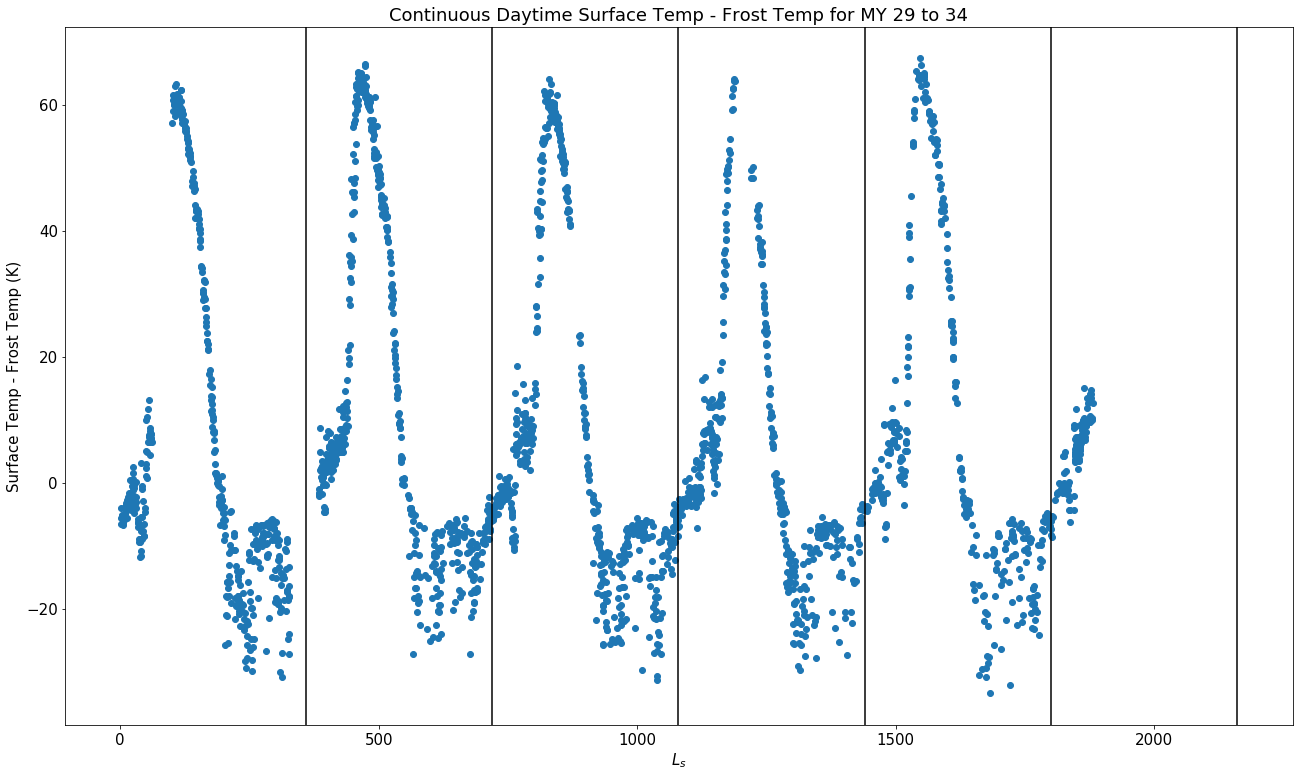

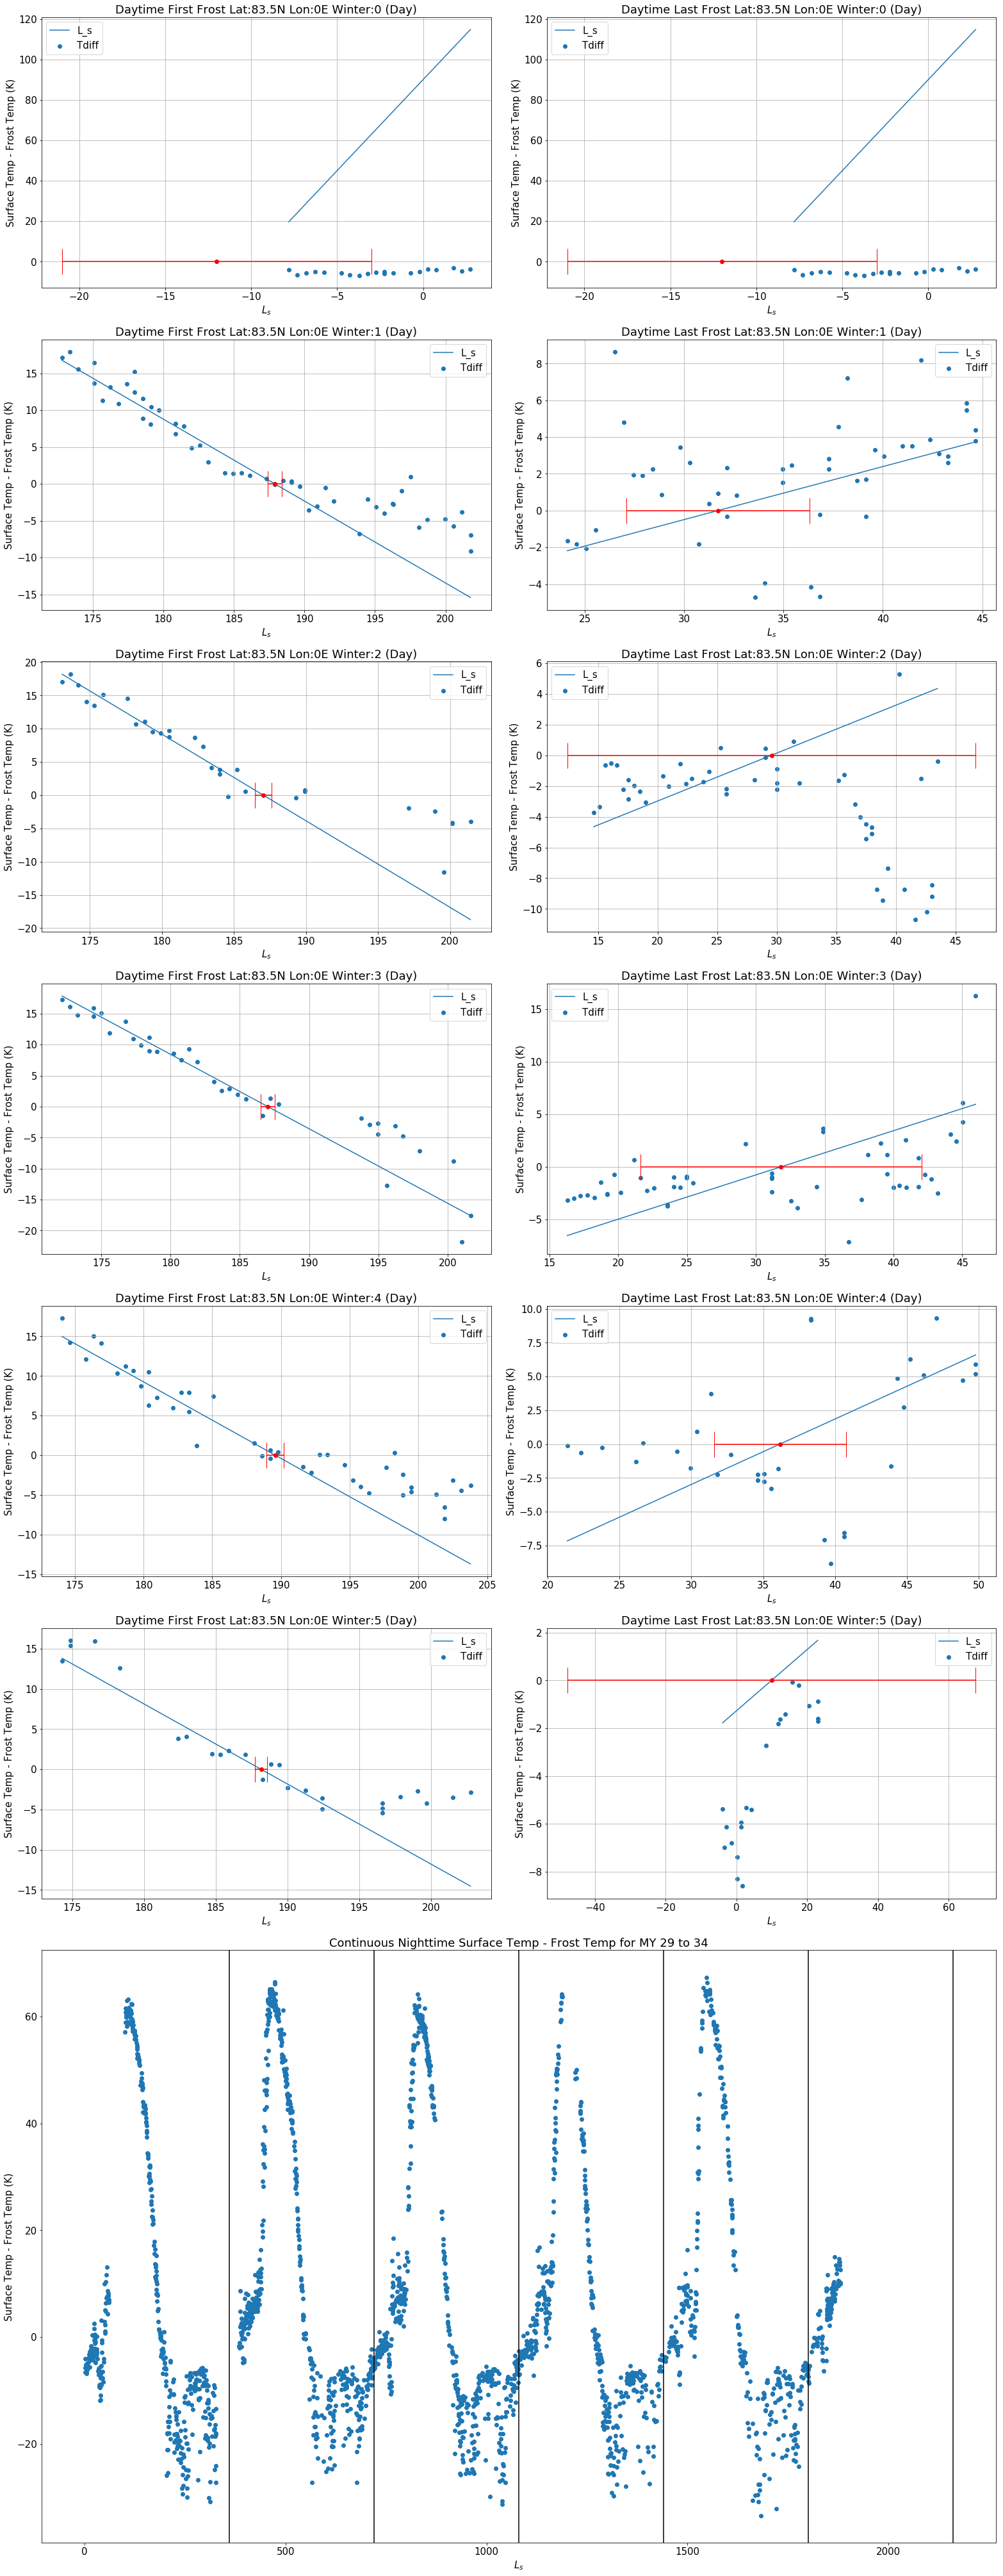

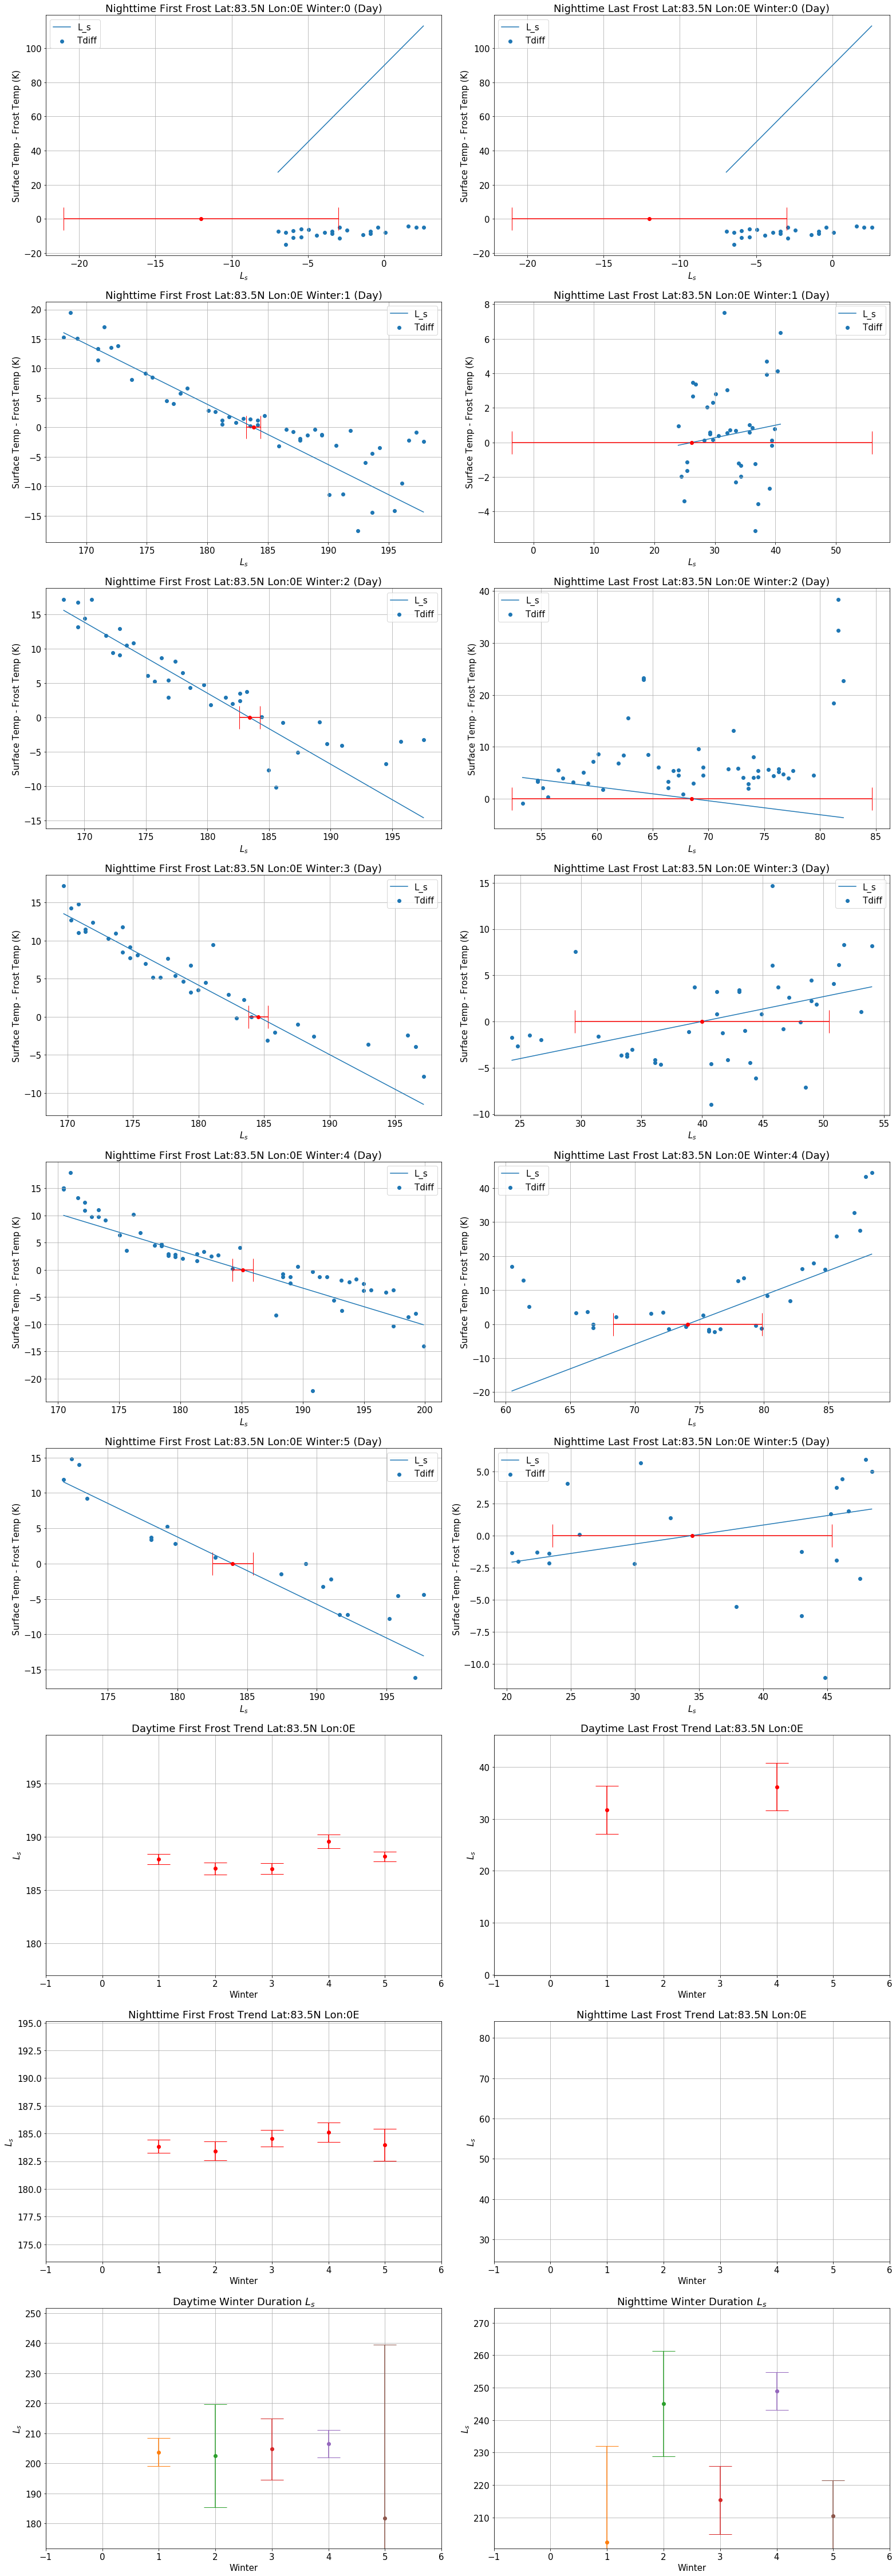

In [136]:
LocationDay, LocationNight= LocFunc(dfday.loc[dfday['MY'] >= Years[0]],
                                    dfnight.loc[dfnight['MY'] >= Years[0]],
                                    CO2day.loc[CO2day['MY'] >= Years[0]],
                                    CO2night.loc[CO2night['MY'] >= Years[0]],
                                    83.5,
                                    0,
                                    Years,
                                    Lsrange = 30,
                                    size=2,
                                    box = 'deg')